In [1]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'

In [9]:
from scipy.optimize import fsolve, root_scalar

R_sun = 8.178

# Function to calculate NFW scale radius given masses at two radii
def calc_NFW_params(M_inner, M_outer, r_inner=R_sun, r_outer=20):
    def mass_ratio(a_NFW, r_inner, r_outer):
        return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
    
    def mass_ratio_diff(a_NFW, M_inner, M_outer, r_inner, r_outer):
        return mass_ratio(a_NFW, r_inner, r_outer) - M_outer/M_inner
    
    initial_guess = 10

    result = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer), full_output=True)

    if result[2] == 1:

        a_NFW = result[0][0]
        rho_0 = M_inner / (4 * np.pi * a_NFW**3) * (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))**(-1)

        return rho_0, a_NFW

    else:
        return np.nan, np.nan

# Function to calculate potential from local circular velocity and NFW scale radius
def make_pot(vcirc_sun, M20, pot_axi_baryon):
    # Circular speed
    vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

    # Calculate model NFW parameters
    Menc_sun_dark = R_sun * vcirc_dark**2 / agama.G
    M20_baryon = pot_axi_baryon.enclosedMass(20)
    M20_dark = M20*1e11 - M20_baryon
    
    rho_0, a_NFW = calc_NFW_params(Menc_sun_dark, M20_dark)

    print(rho_0, a_NFW)

    if (np.isnan(rho_0) == False)*(np.isnan(a_NFW) == False):

        # Make DM potential
        pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

        # And total potential
        pot_mod = agama.Potential(pot_axi_baryon, pot_dark)

        return pot_mod
    
    # Return error value of -1 if potential impossible
    else:
        return -1

11449369.370078051 16.060983836783233


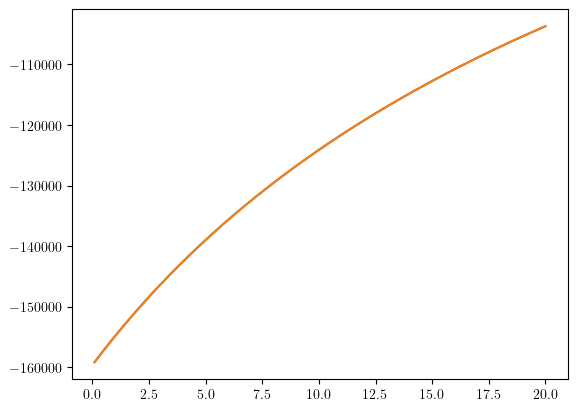

In [ ]:
'''Make potential'''

# Load baryonic potential
pot_axi_Hunter_baryon = agama.Potential(agama_pot_path+'MWPotentialHunter24_baryon_axi.ini')
pot_axi_baryon = pot_axi_Hunter_baryon

# Choose circular velocity at Sun's radius and mass enclosed
vc0 = 233.1 #km/s
M20 = 2.17  #10^11 M_sun

pot = make_pot(233.1, 2.17, pot_axi_baryon)

